# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Helper Functions/Decorators</span>**](#Helper-Functions)
* [**<span>5. LightGBM Model</span>**](#LightGBM-Model) 

## Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

## Helper-Functions

In [15]:
from datetime import datetime, timedelta

# only use last x weeks of transactions data since data is too large
def filter_transactions_last_x_weeks(transactions, x = 10):
    # Convert date strings to datetime objects
    transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

    # Calculate the date x weeks ago from the latest transaction date
    latest_date = transactions['t_dat'].max()
    cutoff_date = latest_date - timedelta(weeks=x)

    # Filter transactions to only include those in the last x weeks
    filtered_transactions = transactions.loc[transactions['t_dat'] >= cutoff_date].copy()

    return filtered_transactions

In [16]:
def filter_customers_and_articles(customers, articles, filtered_transactions):
    # Get unique customer and article IDs from filtered transactions
    customer_ids = filtered_transactions['customer_id'].unique()
    article_ids = filtered_transactions['article_id'].unique()

    # Filter customers and articles to only include those in filtered transactions
    customers_filtered = customers.loc[customers['customer_id'].isin(customer_ids)].copy()
    articles_filtered = articles.loc[articles['article_id'].isin(article_ids)].copy()

    return customers_filtered, articles_filtered

## LightGBM

A comparison of the top GBDT models today. LightGBM is the fastest to train.

|Feature|LightGBM|XGBoost|CatBoost|
|:----|:----|:----|:----|
|Categoricals|Supports categorical features via one-hot encoding|Supports categorical features via one-hot encoding|Automatically handles categorical features using embeddings|
|Speed|Very fast training and prediction|Fast training and prediction|Slower than LightGBM and XGBoost|
|Handling Bias|Handles unbalanced classes via 'is_unbalance'|Handles unbalanced classes via 'scale_pos_weight'|Automatically handles unbalanced classes|
|Handling NaNs|Handles NaN values natively|Requires manual handling of NaNs|Automatically handles NaN values using special category|
|Custom Loss|Supports custom loss functions|Supports custom loss functions|Supports custom loss functions|


To use LightGBM for a ranking problem, we treat this as a binary classification problem where the target variable is whether an item is relevant or not to the user.

Alternatively, we can use LightGBM's ranking API, which is designed for ranking problems. Instead of optimizing for accuracy, the ranking API optimizes for ranking metric MAP (MAP support deprecated however). 

### Feature Engineering

In [17]:
# LightGBM imports

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [18]:
import pickle

# open user_item_matrix_200
with open('user_item_matrix_200.pkl', 'rb') as f:
    user_item_matrix = pickle.load(f)

# open customer and articels incides map
with open('lightgbm/customer_id_indices_map.pkl', 'rb') as f:
    customer_id_indices_map = pickle.load(f)

with open('lightgbm/article_id_indices_map.pkl', 'rb') as f:
    article_id_indices_map = pickle.load(f)

# load df from pickle file for time-based split
with open('lightgbm/df.pkl', 'rb') as f:
    df = pickle.load(f)

# load final_df from pickle file for clean processing
with open('lightgbm/final_df_with_binary_targets.pkl', 'rb') as f:
    final_df = pickle.load(f)

### Model Training

In [19]:
final_df.head()

,price,sales_channel_1,sales_channel_2,quantity,article_engagement_ratio,user_index,item_index,FN,Active,club_member_status,...,garment_group_no_1019.0,garment_group_no_1020.0,garment_group_no_1021.0,garment_group_no_1023.0,garment_group_no_1025.0,index_group_no_1.0,index_group_no_2.0,index_group_no_3.0,index_group_no_4.0,index_group_no_26.0
0,0.042358,False,True,1.0,1.000000,5,11563,1.0,1.0,2.0,...,False,False,False,False,False,True,False,False,False,False
1,0.050842,False,True,1.0,1.000000,5,9899,1.0,1.0,2.0,...,False,False,False,False,False,True,False,False,False,False
2,0.067810,False,True,1.0,1.000000,5,14438,1.0,1.0,2.0,...,False,False,False,False,False,True,False,False,False,False
3,0.016937,False,True,1.0,0.500000,10,10307,0.0,0.0,2.0,...,False,False,False,False,False,False,True,False,False,False
4,0.016937,False,True,1.0,0.166667,10,13608,0.0,0.0,2.0,...,False,False,False,True,False,True,False,False,False,False


In [20]:
def time_based_train_test_split(final_df, test_size=0.2):

    # Convert days, months, and years columns to datetime object
    final_df['date'] = pd.to_datetime(final_df[['day', 'month', 'year']])

    # Sort dataframe by date in ascending order
    final_df = final_df.sort_values(by='date')

    # Calculate cutoff index
    cutoff_index = int(len(final_df) * (1-test_size))

    # Create train and test dataframes
    train_df = final_df[:cutoff_index]
    test_df = final_df[cutoff_index:]

    # Drop date column from train and test dataframes
    train_df = train_df.drop('date', axis=1)
    test_df = test_df.drop('date', axis=1)

    # split train_df into X_train and y_train
    X_train = train_df.drop('target', axis=1)
    y_train = train_df['target']

    # split test_df into X_test and y_test
    X_test = test_df.drop('target', axis=1)
    y_test = test_df['target']

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = time_based_train_test_split(final_df, test_size=0.2)

# drop date column from final_df
final_df = final_df.drop('date', axis=1)

#print the shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6242440, 55)
(1560611, 55)
(6242440,)
(1560611,)


In [9]:
# target encoding
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold

# Define columns to target encode
cols_to_encode = ['department_no', 'product_type_no', 'section_no', 'graphical_appearance_no']

# Define number of folds for cross-validation
n_splits = 5

# Create KFold object for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform target encoding with cross-validation
for col in cols_to_encode:
    final_df[f'{col}_te'] = 0
    te = TargetEncoder(cols=[col])
    for train_idx, val_idx in kf.split(final_df):
        te.fit(final_df.iloc[train_idx][[col]], final_df.iloc[train_idx]['target'])
        final_df.loc[val_idx, f'{col}_te'] = te.transform(final_df.iloc[val_idx][[col]]).values.flatten()

In [22]:
# print all unique values of department_no_te

# drop ['department_no', 'product_type_no', 'section_no', 'graphical_appearance_no'] from final_df
# final_df = final_df.drop(cols_to_encode, axis=1)

final_df.columns


Index(['price', 'sales_channel_1', 'sales_channel_2', 'quantity',
       'article_engagement_ratio', 'user_index', 'item_index', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'time_diff_days',
       'user_purchase_quant', 'product_type_no', 'graphical_appearance_no',
       'department_no', 'section_no', 'age_diff', 'mean_purchase_age',
       'max_purchase_age', 'min_purchase_age', 'article_preference',
       'item_purchase_frequency', 'item_avg_price_level', 'year', 'month',
       'day', 'RFM_Score', 'target', 'garment_group_no_1001.0',
       'garment_group_no_1002.0', 'garment_group_no_1003.0',
       'garment_group_no_1005.0', 'garment_group_no_1006.0',
       'garment_group_no_1007.0', 'garment_group_no_1008.0',
       'garment_group_no_1009.0', 'garment_group_no_1010.0',
       'garment_group_no_1011.0', 'garment_group_no_1012.0',
       'garment_group_no_1013.0', 'garment_group_no_1014.0',
       'garment_group_no_1016.0', 'garment_group_no_10

In [27]:
# ---- memory optimizations -------------

# reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# iterate through all the columns of a dataframe and reduce the int and float data types to the smallest possible size, ex. customer_id should not be reduced from int64 to a samller value as it would have collisions
import numpy as np
import pandas as pd

def reduce_mem_usage(df):
    """Iterate over all the columns of a DataFrame and modify the data type
    to reduce memory usage, handling ordered Categoricals"""
    
    # check the memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'category':
            if df[col].cat.ordered:
                # Convert ordered Categorical to an integer
                df[col] = df[col].cat.codes.astype('int16')
            else:
                # Convert unordered Categorical to a string
                df[col] = df[col].astype('str')
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # check the memory usage after optimization
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))

    # calculate the percentage of the memory usage reduction
    mem_reduction = 100 * (start_mem - end_mem) / start_mem
    print("Memory usage decreased by {:.1f}%".format(mem_reduction))
    
    return df

In [28]:
final_df = reduce_mem_usage(final_df)

# print dtypes for all columns in final_df
final_df.dtypes

Memory usage of dataframe is 1741.33 MB
Memory usage after optimization is: 863.22 MB
Memory usage decreased by 50.4%


price                       float16
sales_channel_1             float16
sales_channel_2             float16
quantity                    float16
article_engagement_ratio    float16
user_index                    int16
item_index                    int32
FN                          float16
Active                      float16
club_member_status          float16
fashion_news_frequency      float16
age                         float16
time_diff_days              float16
user_purchase_quant         float16
product_type_no             float16
graphical_appearance_no     float32
department_no               float16
section_no                  float16
age_diff                    float16
mean_purchase_age           float16
max_purchase_age            float16
min_purchase_age            float16
article_preference          float16
item_purchase_frequency     float16
item_avg_price_level        float16
year                        float16
month                       float16
day                         

In [23]:
# 80/20 time-based split to curb data leakage
X_train, X_test, y_train, y_test = time_based_train_test_split(final_df, test_size=0.2)
final_df = final_df.drop('date', axis=1)

# print the shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6242440, 55)
(1560611, 55)
(6242440,)
(1560611,)


<Axes: >

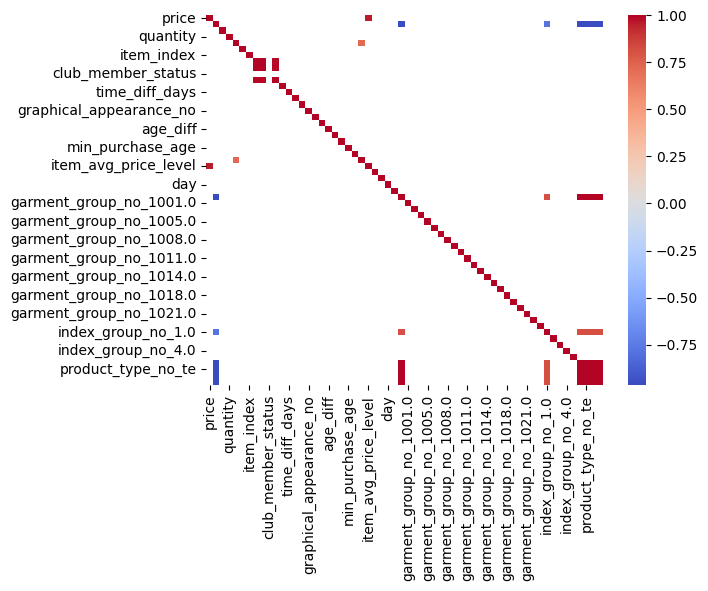

In [12]:
import pandas as pd
import seaborn as sns


# Compute the correlation matrix
corr_matrix = final_df.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix[corr_matrix.abs() > 0.7], cmap='coolwarm')

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score
from sklearn.feature_selection import RFECV
import joblib
from sklearn.metrics import get_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define features and target
features = final_df.columns.tolist()
features.remove('target')
target = 'target'

# Group data by user -- so that LightGBM knows which data points belong to each user and can compute the metrics correctly
grouped_data_train = X_train.groupby('user_index')
grouped_data_test = X_test.groupby('user_index')
groups = [grouped_data_train.groups[user] for user in grouped_data_train.groups.keys()]

# for the clf.fit() ?
groups_flat = np.concatenate(groups)

# Create LightGBM datasets with group query information
train_data = lgb.Dataset(X_train, label=y_train, group=grouped_data_train.groups.values())
test_data = lgb.Dataset(X_test, label=y_test, group=grouped_data_test.groups.values())

# Define hyperparameters space
param_dist = {
    'lgbm__learning_rate': stats.uniform(0.01, 0.1),
    'lgbm__num_leaves': stats.randint(15, 64),
    'lgbm__bagging_fraction': stats.uniform(0.6, 0.4),
    'lgbm__feature_fraction': stats.uniform(0.6, 0.4),
}

# Create a pipeline that includes RFECV
selector = RFECV(estimator=lgb.LGBMClassifier(**param_dist), cv=2, scoring=get_scorer('average_precision'))
pipeline = Pipeline(steps=[('selector', selector), ('lgbm', lgb.LGBMClassifier(**param_dist))])

# Add num_boost_round parameter to lgbm estimator in pipeline
pipeline.named_steps['lgbm'].set_params(num_boost_round=100)

# Perform random search on the pipeline
clf = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=2, scoring=get_scorer('average_precision'), n_iter=5,
                         n_jobs=-1, verbose=2, refit=True, error_score='raise')

clf.fit(X_train, y_train, groups=groups_flat)

# Save the best intermediate model
joblib.dump(clf.best_estimator_, 'best_model.pkl')
print(f'Best hyperparameters: {clf.best_params_}')
print(f'Best map score: {clf.best_score_}')

# Save the selected features
selected_features = X_train_sel.columns.tolist()
joblib.dump(selected_features, 'lightgbm/selected_features.pkl')

# Evaluate the best model on the test set
y_pred = clf.best_estimator_.predict(X_test_sel, num_iteration=clf.best_estimator_.best_iteration_)
ndcg = ndcg_score(y_test, y_pred, group_scores=True, verbose=1)
print(f'NDCG score on test set: {ndcg}')

Fitting 2 folds for each of 5 candidates, totalling 10 fits


MemoryError: Unable to allocate 655. MiB for an array with shape (55, 1560610) and data type float64

Once the model is trained, it can be used to predict the probability of purchase for new user-product pairs, which can be used to generate recommendations for users.

In [ ]:
def select_popular_products(df, n_products=500):
    # Group the dataframe by product and sum the quantity for each product
    product_quantities = df.groupby('item_index')['quantity'].sum()
    # Sort the products by quantity in descending order and select the top n_products
    popular_products = product_quantities.sort_values(ascending=False).index.tolist()[:n_products]
    # Filter the dataframe to only include the popular products
    df = df[df['item_index'].isin(popular_products)]
    return df

In [ ]:
df.head()

If we treat this as a binary classification problem: After training the model, we can then get the probability that each user is likely to purchase an item from a candidate set of items. We can then sort these by descending probability to get the top 12 products as done below. <br>

A heuristic apparoach that we use to enhance LighGBM predictions here: <br>
1. Get a candidate set of top 500 most popular articles (by total purchase quanitity). <br>
2. Include the customer's predicitons to this set. <br>
3. Use lightGBM to predict the probability of purchases, and get the top 12. <br>

In [ ]:
# Assume X is the input data for the LightGBM model
# X has a row for each user-product pair and a binary target indicating whether the user purchased the product or not

# Train the LightGBM model on X
# lgb_model = lgb.LGBMClassifier(**best_params)
# lgb_model.fit(X, y)

# Generate candidate products for each user
# This can be done using a combination of popular products and user purchase history
# Let's assume we have a dictionary 'user_products' that maps each user ID to a list of products they've purchased
user_candidates = {}
for user_id in user_products:
    # Select the 600 most popular products
    popular_products = select_popular_products(500)
    
    # Add user purchase history to candidate list
    user_history = user_products[user_id]
    candidate_products = list(set(popular_products + user_history))
    
    # Store candidate products for this user
    user_candidates[user_id] = candidate_products

# Predict probabilities of purchase for each candidate product for each user
user_scores = {}
for user_id, candidates in user_candidates.items():
    # Create input data for this user
    user_data = create_user_data(user_id, candidates)
    
    # Predict probabilities using the LightGBM model
    scores = lgb_model.predict_proba(user_data)[:, 1]
    
    # Store scores for this user
    user_scores[user_id] = scores

# Rank candidate products for each user and return top 12 as recommendations
recommendations = {}
for user_id, scores in user_scores.items():
    # Sort candidate products by descending score
    candidate_products = user_candidates[user_id]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_products = [candidate_products[i] for i in sorted_indices]
    
    # Select top 12 products
    top_products = sorted_products[:12]
    
    # Add user purchase history to top products
    top_products += user_products[user_id]
    
    # Remove duplicates and return as recommendations
    recommendations[user_id] = list(set(top_products))

Since we are using MAP as the evaluation metric, we could also use the LightGBM ranking API instead of the binary classification API. The code to rank article_ids using the lightgbm ranking API is below.

In [ ]:
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.metrics import average_precision_score
# from sklearn.model_selection import ParameterGrid
# import numpy as np
# import pickle
# import os

# target = 'item_index'
# features = final_df.columns.tolist()
# features.remove(target)

# # split the data into training and test sets -- can also do time-based split
# X_train, X_test, y_train, y_test = train_test_split(final_df[features], final_df[target], test_size=0.2, random_state=42)

# # for number of items to rank for each user (group param for ordered ranking)
# num_items_per_user = 12
# user_indices = X_test.index.unique()
# query = [num_items_per_user] * len(user_indices)
# query_ids = []
# for user_index in user_indices:
#     user_indices_repeated = [user_index] * num_items_per_user
#     query_ids.extend(user_indices_repeated)

# train_data = lgb.Dataset(X_train, label=y_train, group=query_ids)

# # MAP@12 metric
# def mean_average_precision(y_true, y_score, k=12):
#     # get the indices of the top k scores
#     top_k_indices = np.argsort(y_score)[::-1][:k]

#     # calculate average precision at k
#     return average_precision_score(y_true[top_k_indices], y_score[top_k_indices])

# # define hyperparameters for tuning
# params = {
# 'objective': 'lambdarank', #using lightgbm ranking API
# 'metric': 'MAP',
# 'learning_rate': 0.05,
# 'num_leaves': 31,
# 'max_depth': 5,
# 'min_data_in_leaf': 50,
# 'feature_fraction': 0.8,
# 'bagging_fraction': 0.8,
# 'bagging_freq': 5
# }

# # create LightGBM model
# model = lgb.LGBMRanker()

# # perform grid search with cross-validation
# param_grid = {
# 'num_leaves': [31, 50, 75],
# 'max_depth': [5, 7, -1],
# 'min_data_in_leaf': [20, 50, 100],
# 'feature_fraction': [0.6, 0.8, 1],
# 'bagging_fraction': [0.6, 0.8, 1],
# 'bagging_freq': [1, 3, 5],
# 'lambda_l1': [0, 1, 2],
# 'lambda_l2': [0, 1, 2]
# }

# best_map_score = 0.0
# best_model = None

# for params_dict in ParameterGrid(param_grid):
#     params.update(params_dict)
#     model = lgb.train(params, train_data)
#     y_pred = model.predict(X_test, group=query)
#     map_score = mean_average_precision(y_test, y_pred, k=12)
#     if map_score > best_map_score:
#         best_map_score = map_score
#         best_model = model
#         with open(f"lightgbm/grid_search_model_{map_score:.4f}.pickle", 'wb') as f:
#             pickle.dump(model, f)

# # save the best model
# if not os.path.exists('lightgbm'):
#     os.makedirs('lightgbm')
# with open('lightgbm/best_model.pickle', 'wb') as f:
#     pickle.dump(best_model, f)

# # print the best MAP score
# print(f"Best mean average precision: {best_map_score}")